<a href="https://colab.research.google.com/github/renewable-energy-experiments/carbonfoorprint/blob/master/Monthly_Carbon_Emission_in_ISONE_CAISO_NWISO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monthly Carbon Emission in ISONE CAISO NWISO

# Table of Contents
* [1. DataSet Description](#section-one)
* [2. Import and Preprocessing](#section-two)
* [3. Filler and Filter](#section-three)
* [4. Monthly Graphs](#section-four)
* [5. Carbon Emission vs Fuel Monthly Graphs](#section-five)
* [6. Carbon Emission Annual Graphs](#section-six)

<a id="section-one"></a>
# 1.DataSet Description

Dataset is 1 fuel mix  in year 2020 from  EIA for 
[1] CA ISO ( California)

[2] ISO New England 

[3] NorthWest ISO 

<a id="section-two"></a>
# 2.Import & Preprocessing

Let's have a first look at the data. For the sake of simplicity we are only looking at data of plant 1 (power generation and weather). Data of power plant 2 can then be explored in a similar manner.

In [173]:
import os
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates 
xformatter = mdates.DateFormatter('%H:%M') # for time axis plots

# import plotly.offline as py
# py.init_notebook_mode(connected=True)

import sklearn
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')

In [174]:
from google.colab import drive
drive.mount('/content/drive')
import glob
from zipfile import ZipFile

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## column_list_Mwh and color list

In [175]:
column_list_Mwh= ['Wind Generation (MWh)','Solar Generation (MWh)', 'Hydro Generation (MWh)','Other Generation (MWh)', 'Petroleum Generation (MWh)','Natural gas Generation (MWh)', 'Coal Generation (MWh)','Nuclear Generation (MWh)','Battery Generation (MWh)','Imports Generation (MWh)']
column_list = ("Wind",    "Solar",  "Hydro",  "Other",    "Petroleum",  "Natural gas", "Coal",     "Nuclear",  "Battery", "Imports")
# color_list  = ["skyblue", "gold",   "teal",   "deeppink", "red",  "brown",      "darkgrey", "green",    "aqua"  , "grey"]

In [176]:
region = "north_west"

dfwhole = pd.DataFrame()
filenames = glob.glob('/content/drive/MyDrive/power/dataset/'+region+'2020/*.csv')
filenames.sort()

for a in filenames:
    print(a)
    temp = pd.read_csv(a)

    # temp.rename(columns=temp.iloc[0], inplace = True)

    format = '%Y-%m-%d %H:%M:%S'
    temp['Timestamp'] = pd.to_datetime(temp['Timestamp (Hour Ending)'],format = format, errors='ignore')

    for col in column_list_Mwh:
      if col not in temp.columns:
          temp[col] = 0

    temp["total Generation (MWh)"] = temp[np.array(column_list_Mwh)].sum(axis=1)

    dfwhole = dfwhole.append(temp)

dfwhole = dfwhole.reset_index(drop=True)
    
dfwhole.columns

/content/drive/MyDrive/power/dataset/north_west2020/930-data-export-01.csv
/content/drive/MyDrive/power/dataset/north_west2020/930-data-export-02.csv
/content/drive/MyDrive/power/dataset/north_west2020/930-data-export-03.csv
/content/drive/MyDrive/power/dataset/north_west2020/930-data-export-04.csv
/content/drive/MyDrive/power/dataset/north_west2020/930-data-export-05.csv
/content/drive/MyDrive/power/dataset/north_west2020/930-data-export-06.csv
/content/drive/MyDrive/power/dataset/north_west2020/930-data-export-07.csv
/content/drive/MyDrive/power/dataset/north_west2020/930-data-export-08.csv
/content/drive/MyDrive/power/dataset/north_west2020/930-data-export-09.csv
/content/drive/MyDrive/power/dataset/north_west2020/930-data-export-10 (1).csv
/content/drive/MyDrive/power/dataset/north_west2020/930-data-export-10.csv
/content/drive/MyDrive/power/dataset/north_west2020/930-data-export-11.csv
/content/drive/MyDrive/power/dataset/north_west2020/930-data-export-12.csv


Index(['Region Code', 'Timestamp (Hour Ending)', 'Wind Generation (MWh)',
       'Solar Generation (MWh)', 'Hydro Generation (MWh)',
       'Other Generation (MWh)', 'Petroleum Generation (MWh)',
       'Natural gas Generation (MWh)', 'Coal Generation (MWh)',
       'Nuclear Generation (MWh)', 'Timestamp', 'Battery Generation (MWh)',
       'Imports Generation (MWh)', 'total Generation (MWh)'],
      dtype='object')

In [177]:
dfwhole["DATE"] = pd.to_datetime(dfwhole["Timestamp"]).dt.date # add new column with date
dfwhole["TIME"] = pd.to_datetime(dfwhole["Timestamp"]).dt.time # add new column with time
# temp['HOURS'] = pd.to_datetime(temp['TIME']).dt.hour # add new column with hour

dfwhole['Datestamp'] = pd.to_datetime(dfwhole['DATE'].apply(str) +' '+ dfwhole['TIME'].apply(str), format = '%Y-%m-%d %H:%M:%S')


In [178]:
dfwhole["DATE"].count()/24

366.5

In [179]:
months = (dfwhole['Datestamp'].dt.strftime('%b-%Y')).unique()
print(months)

dfwhole[dfwhole['Datestamp'].dt.strftime('%b-%Y')=="Oct-2020"]

['Jan-2020' 'Feb-2020' 'Mar-2020' 'Apr-2020' 'May-2020' 'Jun-2020'
 'Jul-2020' 'Aug-2020' 'Sep-2020' 'Oct-2020' 'Nov-2020' 'Dec-2020'
 'Jan-2021']


,Region Code,Timestamp (Hour Ending),Wind Generation (MWh),Solar Generation (MWh),Hydro Generation (MWh),Other Generation (MWh),Petroleum Generation (MWh),Natural gas Generation (MWh),Coal Generation (MWh),Nuclear Generation (MWh),Timestamp,Battery Generation (MWh),Imports Generation (MWh),total Generation (MWh),DATE,TIME,Datestamp
6583,NW,10/1/2020 12 a.m. PDT,2148,0,10367,901,57,9182,8408,1148,10/1/2020 12 a.m. PDT,0,0,32211,2020-10-01,00:00:00,2020-10-01 00:00:00
6584,NW,10/1/2020 12 a.m. PDT,2148,0,10367,901,57,9182,8408,1148,10/1/2020 12 a.m. PDT,0,0,32211,2020-10-01,00:00:00,2020-10-01 00:00:00
6585,NW,10/1/2020 1 a.m. PDT,2010,-1,9150,933,56,8928,8438,1148,10/1/2020 1 a.m. PDT,0,0,30662,2020-10-01,01:00:00,2020-10-01 01:00:00
6586,NW,10/1/2020 2 a.m. PDT,1871,0,8801,952,57,8653,8427,1151,10/1/2020 2 a.m. PDT,0,0,29912,2020-10-01,02:00:00,2020-10-01 02:00:00
6587,NW,10/1/2020 3 a.m. PDT,1948,-1,8442,948,57,8500,8417,1151,10/1/2020 3 a.m. PDT,0,0,29462,2020-10-01,03:00:00,2020-10-01 03:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7323,NW,10/31/2020 7 p.m. PDT,1840,2,15040,938,58,9031,10307,1161,10/31/2020 7 p.m. PDT,0,0,38377,2020-10-31,19:00:00,2020-10-31 19:00:00
7324,NW,10/31/2020 8 p.m. PDT,1219,-3,14812,959,59,9142,10576,1162,10/31/2020 8 p.m. PDT,0,0,37926,2020-10-31,20:00:00,2020-10-31 20:00:00
7325,NW,10/31/2020 9 p.m. PDT,930,-1,14643,962,57,9243,10588,1163,10/31/2020 9 p.m. PDT,0,0,37585,2020-10-31,21:00:00,2020-10-31 21:00:00
7326,NW,10/31/2020 10 p.m. PDT,931,0,14391,987,58,8994,10406,1164,10/31/2020 10 p.m. PDT,0,0,36931,2020-10-31,22:00:00,2020-10-31 22:00:00


## column_list_percent

In [ ]:
column_list_percent = [ sub.replace("(MWh)","(%)") for sub in column_list_Mwh]
column_list_percent

In [ ]:
column_list_carbon = [ "carbon_"+sub + "(kgeCO2)" for sub in column_list]
column_list_carbon

# Annual Graphs

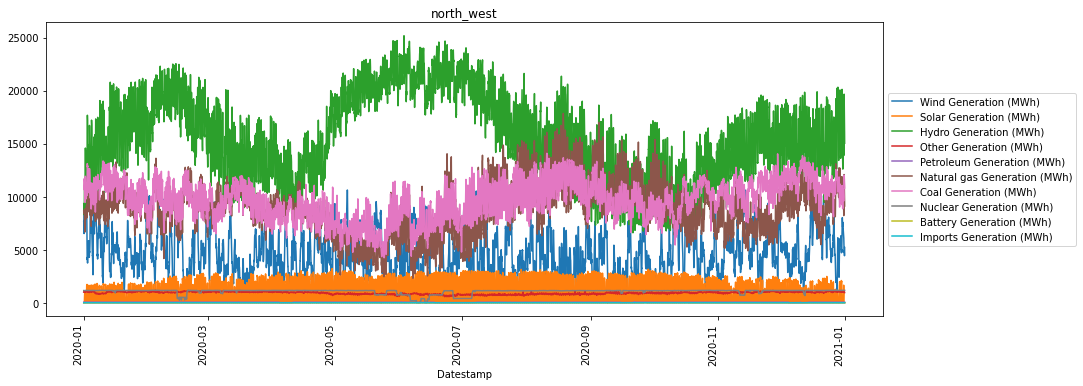

In [180]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
dfwhole.plot(x="Datestamp", 
             y=np.array(column_list_Mwh),
             title = region,
             ax = ax )
plt.xticks(rotation=90)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Annual Carbon Graph

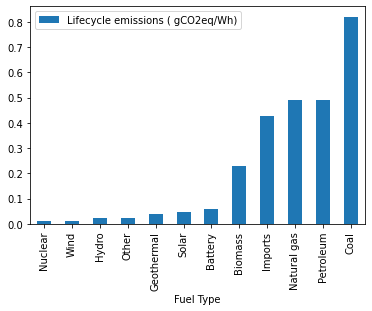

In [181]:
df_carbon = pd.read_csv("/content/drive/MyDrive/power/dataset/lcoe-co2/US Utility grids - LCOE, Co2 Emissions - Carbon4.csv")
df_carbon.sort_values('Lifecycle emissions ( gCO2eq/Wh)',ascending=True).plot( x='Fuel Type',y=["Lifecycle emissions ( gCO2eq/Wh)"],kind='bar')

Percentage fuel consumption from EIA fuel fix per hour

In [182]:
dfwhole["Wind Generation (%)"]= dfwhole["Wind Generation (MWh)"]*100 / dfwhole["total Generation (MWh)"] 
dfwhole["Solar Generation (%)"]= dfwhole["Solar Generation (MWh)"]*100 / dfwhole["total Generation (MWh)"] 
dfwhole["Hydro Generation (%)"]= dfwhole["Hydro Generation (MWh)"]*100 / dfwhole["total Generation (MWh)"] 
dfwhole["Other Generation (%)"]= dfwhole["Other Generation (MWh)"]*100 / dfwhole["total Generation (MWh)"] 
dfwhole["Petroleum Generation (%)"]= dfwhole["Petroleum Generation (MWh)"]*100 / dfwhole["total Generation (MWh)"] 
dfwhole["Natural gas Generation (%)"]= dfwhole["Natural gas Generation (MWh)"]*100 / dfwhole["total Generation (MWh)"] 
dfwhole["Coal Generation (%)"]= dfwhole["Coal Generation (MWh)"]*100 / dfwhole["total Generation (MWh)"] 
dfwhole["Nuclear Generation (%)"]= dfwhole["Nuclear Generation (MWh)"]*100 / dfwhole["total Generation (MWh)"] 
dfwhole["Battery Generation (%)"]= dfwhole["Battery Generation (MWh)"]*100 / dfwhole["total Generation (MWh)"] 
dfwhole["Imports Generation (%)"]= dfwhole["Imports Generation (MWh)"]*100 / dfwhole["total Generation (MWh)"] 
dfwhole.columns
# dfnw.describe()

Index(['Region Code', 'Timestamp (Hour Ending)', 'Wind Generation (MWh)',
       'Solar Generation (MWh)', 'Hydro Generation (MWh)',
       'Other Generation (MWh)', 'Petroleum Generation (MWh)',
       'Natural gas Generation (MWh)', 'Coal Generation (MWh)',
       'Nuclear Generation (MWh)', 'Timestamp', 'Battery Generation (MWh)',
       'Imports Generation (MWh)', 'total Generation (MWh)', 'DATE', 'TIME',
       'Datestamp', 'Wind Generation (%)', 'Solar Generation (%)',
       'Hydro Generation (%)', 'Other Generation (%)',
       'Petroleum Generation (%)', 'Natural gas Generation (%)',
       'Coal Generation (%)', 'Nuclear Generation (%)',
       'Battery Generation (%)', 'Imports Generation (%)'],
      dtype='object')

Graphs for percentage fuel mix 

['Wind Generation (%)',
 'Solar Generation (%)',
 'Hydro Generation (%)',
 'Other Generation (%)',
 'Petroleum Generation (%)',
 'Natural gas Generation (%)',
 'Coal Generation (%)',
 'Nuclear Generation (%)',
 'Battery Generation (%)',
 'Imports Generation (%)']

Text(0, 0.5, 'Fuel Mix (%)')

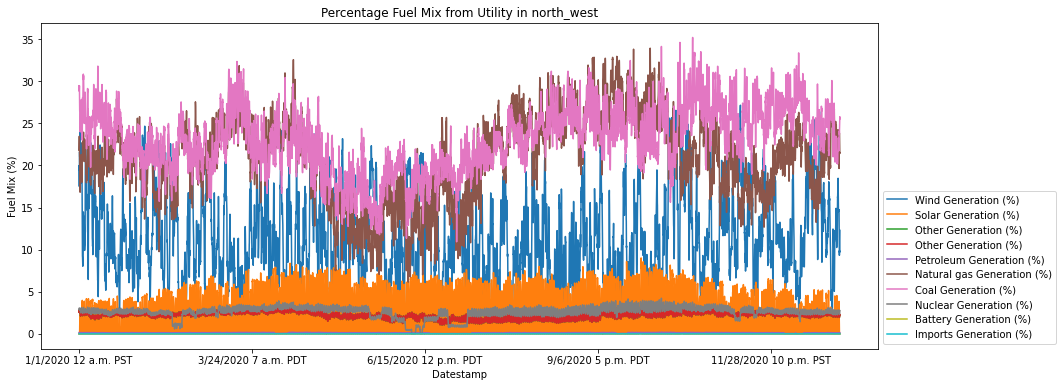

In [184]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
dfwhole.plot(
      x= "Timestamp (Hour Ending)",
      y=["Wind Generation (%)",
      "Solar Generation (%)" , 
      "Other Generation (%)" ,
      "Other Generation (%)" , 
      "Petroleum Generation (%)", 
      "Natural gas Generation (%)", 
      "Coal Generation (%)", 
      "Nuclear Generation (%)",
      "Battery Generation (%)",
      "Imports Generation (%)"],
        title = "Percentage Fuel Mix from Utility in " + region ,
      ax=ax)
ax.legend(loc='bottom left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel("Datestamp")
ax.set_ylabel("Fuel Mix (%)")

Carbon Emission from power by utility geneeation

['carbon_Wind(kgeCO2)',
 'carbon_Solar(kgeCO2)',
 'carbon_Hydro(kgeCO2)',
 'carbon_Other(kgeCO2)',
 'carbon_Petroleum(kgeCO2)',
 'carbon_Natural gas(kgeCO2)',
 'carbon_Coal(kgeCO2)',
 'carbon_Nuclear(kgeCO2)',
 'carbon_Battery(kgeCO2)',
 'carbon_Imports(kgeCO2)']

In [186]:
def df_calculate_carbon(df, columnlist): 
  for col in df[np.array(columnlist)].columns:
    # print(df[col])
    for j,carbon in df_carbon.iterrows():
      if carbon[0] in col:
          print("Match between two tables for "+col+ " and "+ carbon[0] +" - "+ str(carbon[1]))
          df['carbon_'+col.replace(" Generation (MWh)","(kgeCO2)")] = df[col] * carbon[1]# kg/MWh
  df["carbon_total(kgeCO2)"] = df[np.array(column_list_carbon)].sum(axis=1)

In [187]:
df_calculate_carbon(dfwhole, column_list_Mwh)
dfwhole.columns

Match between two tables for Wind Generation (MWh) and Wind - 12
Match between two tables for Solar Generation (MWh) and Solar - 48
Match between two tables for Hydro Generation (MWh) and Hydro - 24
Match between two tables for Other Generation (MWh) and Other - 24
Match between two tables for Petroleum Generation (MWh) and Petroleum - 490
Match between two tables for Natural gas Generation (MWh) and Natural gas - 490
Match between two tables for Coal Generation (MWh) and Coal - 820
Match between two tables for Nuclear Generation (MWh) and Nuclear - 12
Match between two tables for Battery Generation (MWh) and Battery - 59
Match between two tables for Imports Generation (MWh) and Imports - 428


Index(['Region Code', 'Timestamp (Hour Ending)', 'Wind Generation (MWh)',
       'Solar Generation (MWh)', 'Hydro Generation (MWh)',
       'Other Generation (MWh)', 'Petroleum Generation (MWh)',
       'Natural gas Generation (MWh)', 'Coal Generation (MWh)',
       'Nuclear Generation (MWh)', 'Timestamp', 'Battery Generation (MWh)',
       'Imports Generation (MWh)', 'total Generation (MWh)', 'DATE', 'TIME',
       'Datestamp', 'Wind Generation (%)', 'Solar Generation (%)',
       'Hydro Generation (%)', 'Other Generation (%)',
       'Petroleum Generation (%)', 'Natural gas Generation (%)',
       'Coal Generation (%)', 'Nuclear Generation (%)',
       'Battery Generation (%)', 'Imports Generation (%)',
       'carbon_Wind(kgeCO2)', 'carbon_Solar(kgeCO2)', 'carbon_Hydro(kgeCO2)',
       'carbon_Other(kgeCO2)', 'carbon_Petroleum(kgeCO2)',
       'carbon_Natural gas(kgeCO2)', 'carbon_Coal(kgeCO2)',
       'carbon_Nuclear(kgeCO2)', 'carbon_Battery(kgeCO2)',
       'carbon_Imports(kgeCO2

Text(0, 0.5, 'Carbon Emission from Power Demand (kgeCO2)')

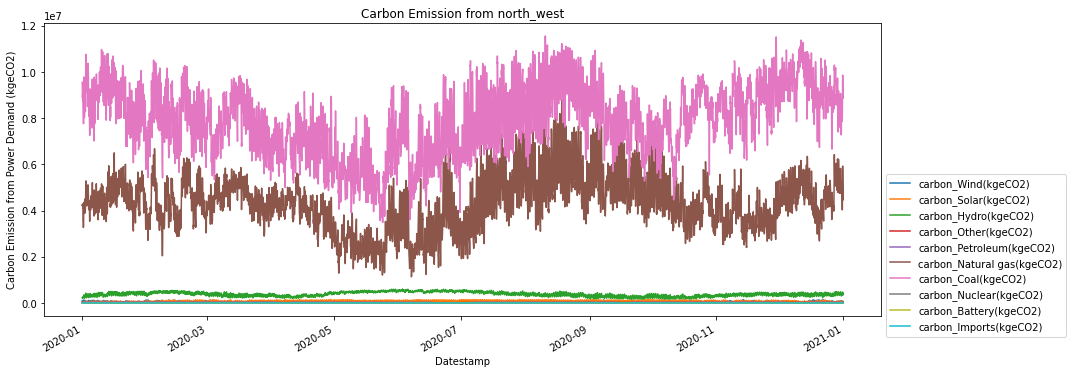

In [188]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
dfwhole.plot( 
    x = "Datestamp",
    y = np.array(column_list_carbon),
    title = "Carbon Emission from "+ region,
    ax=ax) 
ax.legend(loc='bottom left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel("Datestamp")
ax.set_ylabel("Carbon Emission from Power Demand (kgeCO2)")

# Monthly

In [189]:
months_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [190]:
dfwhole.head()

,Region Code,Timestamp (Hour Ending),Wind Generation (MWh),Solar Generation (MWh),Hydro Generation (MWh),Other Generation (MWh),Petroleum Generation (MWh),Natural gas Generation (MWh),Coal Generation (MWh),Nuclear Generation (MWh),Timestamp,Battery Generation (MWh),Imports Generation (MWh),total Generation (MWh),DATE,TIME,Datestamp,Wind Generation (%),Solar Generation (%),Hydro Generation (%),Other Generation (%),Petroleum Generation (%),Natural gas Generation (%),Coal Generation (%),Nuclear Generation (%),Battery Generation (%),Imports Generation (%),carbon_Wind(kgeCO2),carbon_Solar(kgeCO2),carbon_Hydro(kgeCO2),carbon_Other(kgeCO2),carbon_Petroleum(kgeCO2),carbon_Natural gas(kgeCO2),carbon_Coal(kgeCO2),carbon_Nuclear(kgeCO2),carbon_Battery(kgeCO2),carbon_Imports(kgeCO2),carbon_total(kgeCO2)
0,NW,1/1/2020 12 a.m. PST,7689,-1,9348,1013,60,8627,11650,1150,1/1/2020 12 a.m. PST,0,0,39536,2020-01-01,00:00:00,2020-01-01 00:00:00,19.448098,-0.002529,23.644274,2.562222,0.151760,21.820619,29.466815,2.908741,0.0,0.0,92268,-48,224352,24312,29400,4227230,9553000,13800,0,0,14164314
1,NW,1/1/2020 1 a.m. PST,7751,-2,8920,1045,60,8576,11273,1152,1/1/2020 1 a.m. PST,0,0,38775,2020-01-01,01:00:00,2020-01-01 01:00:00,19.989684,-0.005158,23.004513,2.695035,0.154739,22.117344,29.072856,2.970986,0.0,0.0,93012,-96,214080,25080,29400,4202240,9243860,13824,0,0,13821400
2,NW,1/1/2020 2 a.m. PST,7269,1,8590,1063,59,8618,11142,1152,1/1/2020 2 a.m. PST,0,0,37894,2020-01-01,02:00:00,2020-01-01 02:00:00,19.182456,0.002639,22.668496,2.805193,0.155697,22.742387,29.403072,3.040059,0.0,0.0,87228,48,206160,25512,28910,4222820,9136440,13824,0,0,13720942
3,NW,1/1/2020 3 a.m. PST,6892,0,8941,1047,60,8627,10815,1149,1/1/2020 3 a.m. PST,0,0,37531,2020-01-01,03:00:00,2020-01-01 03:00:00,18.363486,0.000000,23.822973,2.789694,0.159868,22.986331,28.816179,3.061469,0.0,0.0,82704,0,214584,25128,29400,4227230,8868300,13788,0,0,13461134
4,NW,1/1/2020 4 a.m. PST,6526,-1,8779,1043,59,8748,10973,1147,1/1/2020 4 a.m. PST,0,0,37274,2020-01-01,04:00:00,2020-01-01 04:00:00,17.508183,-0.002683,23.552610,2.798197,0.158287,23.469443,29.438751,3.077212,0.0,0.0,78312,-48,210696,25032,28910,4286520,8997860,13764,0,0,13641046


In [191]:

# temp["DATETIME"]= pd.to_datetime(temp['DATE'] + ' ' + temp['TIME'])
# temp = temp.set_index('DATETIME')

# days = dfwhole["DATE"].unique()

In [192]:
dfwhole_months = dfwhole.resample('M',on='Datestamp').agg({'Wind Generation (MWh)':'sum', 
                                        'Solar Generation (MWh)':'sum',
                                        'Hydro Generation (MWh)':'sum', 
                                        'Other Generation (MWh)':'sum', 
                                        'Petroleum Generation (MWh)':'sum', 
                                        'Natural gas Generation (MWh)':'sum',
                                        'Coal Generation (MWh)':'sum',
                                        'Nuclear Generation (MWh)':'sum',
                                        'Battery Generation (MWh)':'sum',
                                        'Imports Generation (MWh)':'sum',
                                        'total Generation (MWh)':'sum',
                                        'DATE':'unique'})
dfwhole_months.head(12)

,Wind Generation (MWh),Solar Generation (MWh),Hydro Generation (MWh),Other Generation (MWh),Petroleum Generation (MWh),Natural gas Generation (MWh),Coal Generation (MWh),Nuclear Generation (MWh),Battery Generation (MWh),Imports Generation (MWh),total Generation (MWh),DATE
Datestamp,,,,,,,,,,,,
2020-01-31,3982866,363916,11820111,750064,43907,6953811,7983756,861437,0,0,32759868,"[2020-01-01, 2020-01-02, 2020-01-03, 2020-01-0..."
2020-02-29,3801528,516516,12810276,709150,41404,6237804,6825014,726765,0,0,31668457,"[2020-02-01, 2020-02-02, 2020-02-03, 2020-02-0..."
2020-03-31,3309269,615151,10249841,767130,44095,6947685,7021110,855103,0,0,29809384,"[2020-03-01, 2020-03-02, 2020-03-03, 2020-03-0..."
2020-04-30,3162655,773987,9469679,694711,36683,5979872,5914257,836394,0,0,26868238,"[2020-04-01, 2020-04-02, 2020-04-03, 2020-04-0..."
2020-05-31,3362437,853610,15082021,607822,39974,4001719,5124304,790064,0,0,29861951,"[2020-05-01, 2020-05-02, 2020-05-03, 2020-05-0..."
2020-06-30,3215831,888258,15504071,551688,26485,4787712,5880615,423600,0,0,31278260,"[2020-06-01, 2020-06-02, 2020-06-03, 2020-06-0..."
2020-07-31,3310813,962272,13877091,556618,33628,7121013,7418843,761729,0,0,34042007,"[2020-07-01, 2020-07-02, 2020-07-03, 2020-07-0..."
2020-08-31,3109945,858329,10913262,610036,41578,8500085,8242827,849775,0,0,33125837,"[2020-08-01, 2020-08-02, 2020-08-03, 2020-08-0..."
2020-09-30,2630422,759943,8244727,649819,34372,7685945,6900787,818352,0,0,27724367,"[2020-09-01, 2020-09-02, 2020-09-03, 2020-09-0..."


Energy consumption by month ( bar chart)

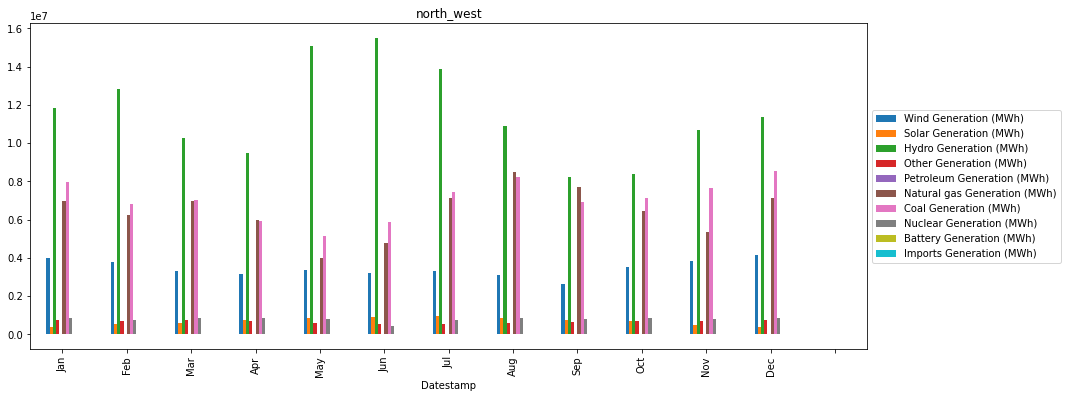

In [193]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)



dfwhole_months.plot.bar( 
             y=np.array(column_list_Mwh),
             title = region,
             ax = ax )
ax.set_xticklabels(months_list)
plt.xticks(rotation=90)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

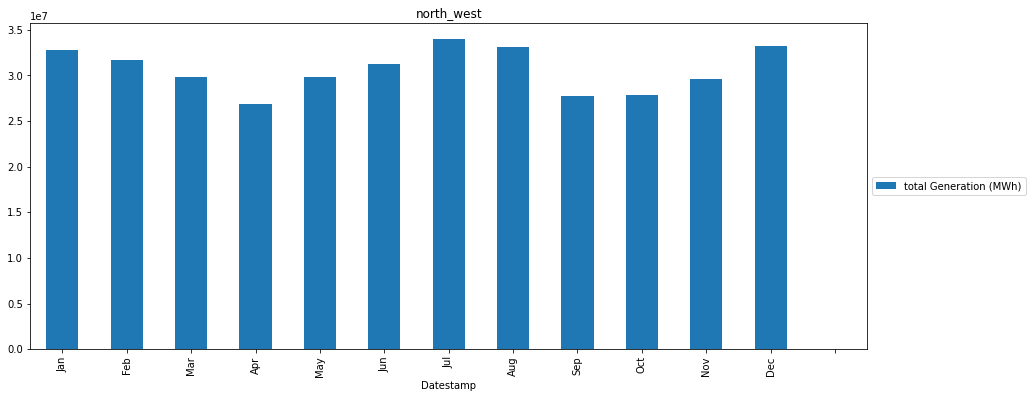

In [194]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
dfwhole_months.plot.bar(
             y= "total Generation (MWh)",
             title = region,
             ax = ax )
ax.set_xticklabels(months_list)
plt.xticks(rotation=90)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Carbon emission by month ( bar chart ) 

In [195]:
dfwhole_months_carbon = dfwhole.resample('M',on='Datestamp').agg({'carbon_Wind(kgeCO2)':'sum', 
                                        'carbon_Solar(kgeCO2)':'sum',
                                        'carbon_Hydro(kgeCO2)':'sum', 
                                        'carbon_Other(kgeCO2)':'sum', 
                                        'carbon_Petroleum(kgeCO2)':'sum', 
                                        'carbon_Natural gas(kgeCO2)':'sum',
                                        'carbon_Coal(kgeCO2)':'sum',
                                        'carbon_Nuclear(kgeCO2)':'sum',
                                        'carbon_Battery(kgeCO2)':'sum',
                                        'carbon_Imports(kgeCO2)':'sum',
                                        'carbon_total(kgeCO2)':'sum',
                                        'DATE':'unique'})
dfwhole_months_carbon.head()

,carbon_Wind(kgeCO2),carbon_Solar(kgeCO2),carbon_Hydro(kgeCO2),carbon_Other(kgeCO2),carbon_Petroleum(kgeCO2),carbon_Natural gas(kgeCO2),carbon_Coal(kgeCO2),carbon_Nuclear(kgeCO2),carbon_Battery(kgeCO2),carbon_Imports(kgeCO2),carbon_total(kgeCO2),DATE
Datestamp,,,,,,,,,,,,
2020-01-31,47794392,17467968,283682664,18001536,21514430,3407367390,6546679920,10337244,0,0,10352845544,"[2020-01-01, 2020-01-02, 2020-01-03, 2020-01-0..."
2020-02-29,45618336,24792768,307446624,17019600,20287960,3056523960,5596511480,8721180,0,0,9076921908,"[2020-02-01, 2020-02-02, 2020-02-03, 2020-02-0..."
2020-03-31,39711228,29527248,245996184,18411120,21606550,3404365650,5757310200,10261236,0,0,9527189416,"[2020-03-01, 2020-03-02, 2020-03-03, 2020-03-0..."
2020-04-30,37951860,37151376,227272296,16673064,17974670,2930137280,4849690740,10036728,0,0,8126888014,"[2020-04-01, 2020-04-02, 2020-04-03, 2020-04-0..."
2020-05-31,40349244,40973280,361968504,14587728,19587260,1960842310,4201929280,9480768,0,0,6649718374,"[2020-05-01, 2020-05-02, 2020-05-03, 2020-05-0..."


Text(0, 0.5, 'Carbon Emission from Power Demand (kgeCO2)')

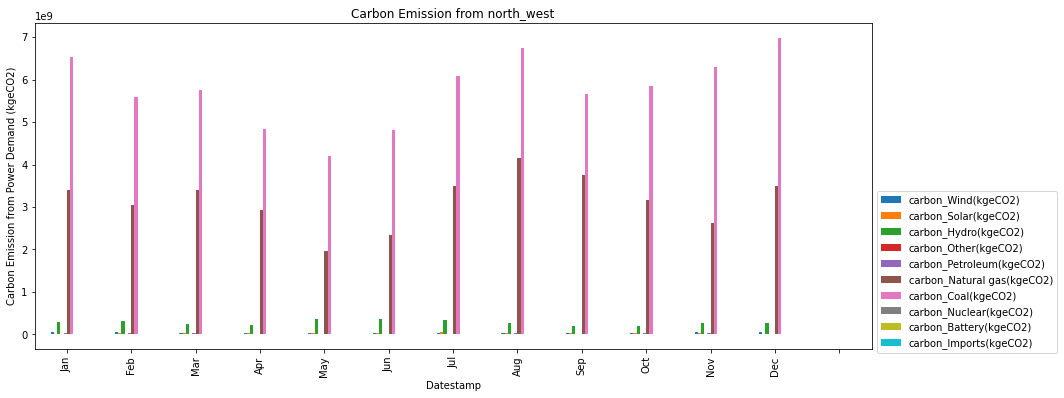

In [196]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
dfwhole_months_carbon.plot.bar( 
    # x = "Datestamp",
    y = np.array(column_list_carbon),
    title = "Carbon Emission from "+ region,
    ax=ax) 
ax.legend(loc='bottom left', bbox_to_anchor=(1.0, 0.5))
ax.set_xticklabels(months_list)
ax.set_xlabel("Datestamp")
ax.set_ylabel("Carbon Emission from Power Demand (kgeCO2)")

Text(0, 0.5, 'Carbon Emission from Power Demand (kgeCO2)')

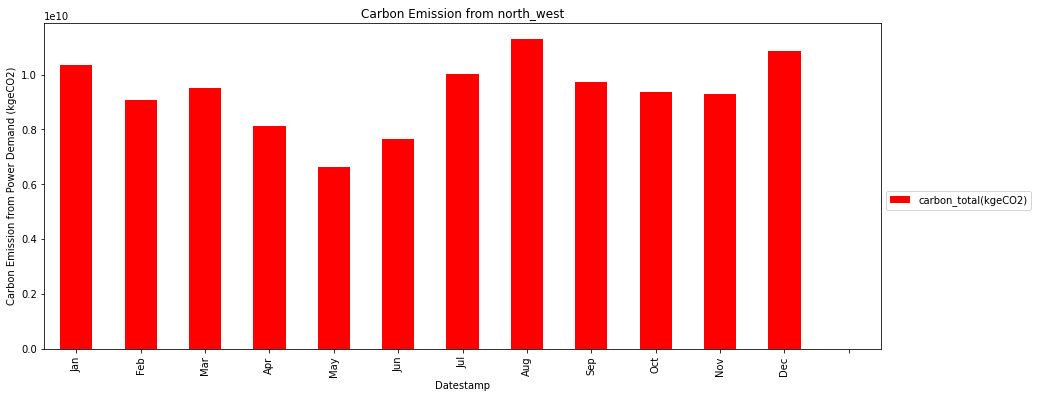

In [197]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
dfwhole_months_carbon.plot.bar( 
    # x = "Datestamp",
    y = ["carbon_total(kgeCO2)"],
    title = "Carbon Emission from "+ region,
    color="red",
    ax=ax) 
ax.legend(loc='bottom left', bbox_to_anchor=(1.0, 0.5))
ax.set_xticklabels(months_list)
ax.set_xlabel("Datestamp")
ax.set_ylabel("Carbon Emission from Power Demand (kgeCO2)")

#  Daily hourly fluctuation throughout the year 

In [198]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15, 6)
# dfwhole_months.plot( x="HOUR",
#              y=np.array(column_list_Mwh),
#              title = region,
#              ax = ax )
# plt.xticks(rotation=90)
# ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# Raw Industrial Energy consumption and carbon footprint 

In [199]:
column_list_power = [ sub + "(W)" for sub in column_list]
column_list_power

['Wind(W)',
 'Solar(W)',
 'Hydro(W)',
 'Other(W)',
 'Petroleum(W)',
 'Natural gas(W)',
 'Coal(W)',
 'Nuclear(W)',
 'Battery(W)',
 'Imports(W)']

In [200]:
def df_calculate_fuelmixbypercent(df, dfpercent):
    if not df["power(W)"].any() :
        print("No power found")
    
    if not dfpercent["Wind Generation (%)"].any() :
        print("No dfpercent found")

    # df_percent_fuelmix = df_percent_fuelmix.reset_index(drop=True)
    # if dfnw["Timestamp (Hour Ending)"].Hour == dfwhole1["Timestamp"].Hour :
    df["Wind(W)"] = dfpercent["Wind Generation (%)"] * df["power(W)"]/100
    df["Solar(W)"] = dfpercent["Solar Generation (%)"] * df["power(W)"]/100
    df["Hydro(W)"] = dfpercent["Hydro Generation (%)"]  * df["power(W)"]/100
    df["Other(W)"] = dfpercent["Other Generation (%)"] * df["power(W)"]/100
    df["Petroleum(W)"] = dfpercent["Petroleum Generation (%)"] * df["power(W)"]/100
    df["Natural gas(W)"] = dfpercent["Natural gas Generation (%)"] * df["power(W)"]/100
    df["Coal(W)"] = dfpercent["Coal Generation (%)"] * df["power(W)"]/100
    df["Nuclear(W)"] = dfpercent["Nuclear Generation (%)"] * df["power(W)"]/100
    df["Battery(W)"] = dfpercent["Battery Generation (%)"] * df["power(W)"]/100
    df["Imports(W)"] = dfpercent["Imports Generation (%)"] * df["power(W)"]/100

    df["total(W)"] = df[np.array(column_list_power)].sum(axis=1)

def df_calculate_carbon2(df, columnlist): 
    for col in df[np.array(columnlist)].columns:
      # print(df[col])
      for j,carbon in df_carbon.iterrows():
        if carbon[0] in col:
            # print("Match between two tables for "+col+ " and "+ carbon[0] +" - "+ str(carbon[1]))
            df['carbon_'+col.replace("(W)","(kgeCO2)")] = df[col] * carbon[2] * 0.001     # Wh * gCO2eq/Wh * 0.001 = eqKgCo2
    df["carbon_total(kgeCO2)"] = df[np.array(column_list_carbon)].sum(axis=1)

In [201]:
# Medium Industry 2009 ( 354 kW - 568 kW )
Region="MediumIndustry2009"
dfindus = pd.read_csv('/content/drive/MyDrive/power/dataset/industrial_energy_comsumption/indust data P_2009.csv')
dfindus.drop(["Unnamed: 4"], axis=1, inplace=True)  
dfindus.drop(["Unnamed: 5"], axis=1, inplace=True)  
dfindus.drop(["kvarh d"], axis=1, inplace=True)  
# print(dfindus.columns)

startdate = datetime.date(2009,1, 1)
enddate = datetime.date(2009, 12, 31)

# dfindus.head()

In [202]:
#nan and not null
dfindus = dfindus[dfindus.Date.notnull()]

dfindus["Date"] = pd.to_datetime(dfindus["Date"],errors='coerce').dt.date #  date
dfindus["Time"] = pd.to_datetime(dfindus["Time"],errors='coerce').dt.time #  time

#timesatmp format
dfindus['Timestamp'] = pd.to_datetime(dfindus['Date'].apply(str) +' '+ dfindus['Time'].apply(str), format = '%Y-%m-%d %H:%M:%S')

#Rename Columns
dfindus =   dfindus.rename(columns={"Date": "DATE",
                            "Time" : "TIME",
                            "kWh d": "energy(kWh)"
                          })
# Remove duplicates 
dfindus = dfindus[dfindus['DATE'].between(startdate, enddate, inclusive=True)]
dfindus = dfindus.sort_values(by=['Timestamp'],ascending=True)
dfindus = dfindus.drop_duplicates(subset='Timestamp', keep="first")

#  Fill undefined and nan
dfindus = dfindus.replace('undefined', 0)
dfindus = dfindus.fillna(0)
dfindus = dfindus.replace(np.nan, 0)
# dfindus = dfindus.set_index('TIME')
# dfindus.index = dfindus['TIME']

#  Power = Energy / Time
dfindus["power(kW)"] = dfindus["energy(kWh)"]* 60/15
dfindus["power(W)"] = dfindus["power(kW)"] * 1000

In [210]:
dfindus_hourly = dfindus.resample('H',on='Timestamp').agg({ 
                                        'power(W)':'mean',
                                        'Timestamp':'first',
                                        'DATE':'unique'})
dfindus_hourly = dfindus_hourly.reset_index(drop=True)

In [212]:
df_calculate_fuelmixbypercent(dfindus_hourly, dfwhole)

In [205]:
# dfindus_hourly = dfindus.resample('H',on='Timestamp').agg({'Wind(W)':'mean', 
#                                         'Solar(W)':'mean',
#                                         'Hydro(W)':'mean', 
#                                         'Other(W)':'mean', 
#                                         'Petroleum(W)':'mean', 
#                                         'Natural gas(W)':'mean',
#                                         'Coal(W)':'mean',
#                                         'Nuclear(W)':'mean',
#                                         'Battery(W)':'mean',
#                                         'Imports(W)':'mean',
#                                         'total(W)':'mean',
#                                         'Timestamp':'first',
#                                         'DATE':'unique'})

In [213]:
df_calculate_carbon2(dfindus_hourly, column_list_power)

In [207]:
dfindus_hourly["Timestamp"].dt.month.unique()

array([ 1.,  2.,  3., nan,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

## graph for Carbon produced from raw 

Text(0, 0.5, 'Carbon Emission (kgCO2eq)')

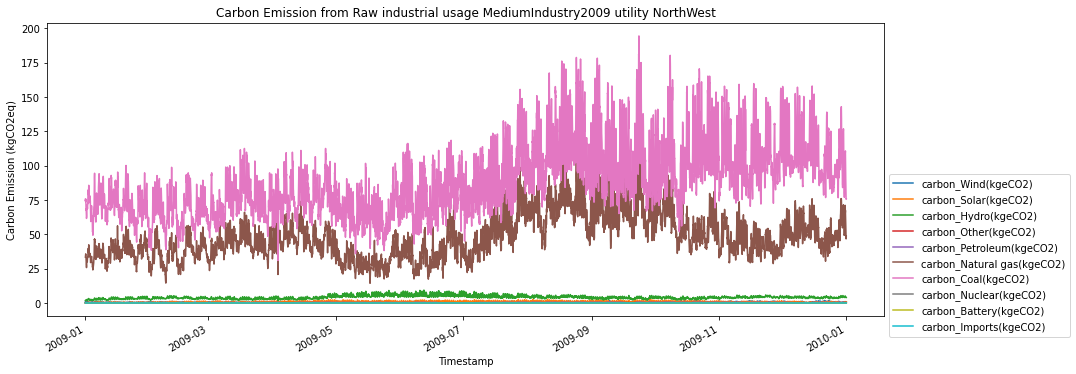

In [246]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
dfindus_hourly.plot( 
    x = "Timestamp",
    y = np.array(column_list_carbon),
    title = "Carbon Emission from Raw industrial usage "+ Region +" utility "+ utilityregion ,
    ax=ax) 
ax.legend(loc='bottom left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel("Timestamp")
ax.set_ylabel("Carbon Emission (kgCO2eq)")
# ax.set_xticklabels(months_list)

Monthly Raw industrial carbon emission

In [215]:
# dfindus = dfindus.resample('M',on='Timestamp').agg({'Wind(W)':'mean', 
#                                         'Solar(W)':'mean',
#                                         'Hydro(W)':'mean', 
#                                         'Other(W)':'mean', 
#                                         'Petroleum(W)':'mean', 
#                                         'Natural gas(W)':'mean',
#                                         'Coal(W)':'mean',
#                                         'Nuclear(W)':'mean',
#                                         'Battery(W)':'mean',
#                                         'Imports(W)':'mean',
#                                         'total(W)':'mean',
#                                         'Timestamp':'first',
#                                         'DATE':'unique'})

# Industrial Energy consumption and carbon footprint after Behind-the-meter storage

In [ ]:
utilityregion = "NorthWest"
industry = "indust1_seattle_pricing"
name = "load_aft_batt_on_grid.txt_11310000.0_hwb"

print( industry + " " + name + " "+ utilityregion)
dfbattery0 = pd.read_csv('/content/drive/MyDrive/power/dataset/'+industry+'/'+name ,header=None)
# dfbattery0['DATE'] = pd.to_datetime(dfbattery[0],format = '%m_%d_%Y').dt.date

dfbattery0.head()

In [ ]:
# r1 = pd.DataFrame(columns=["Power(W)","DATE"])
# r1["Power(W)"] = row.iloc[0]
# date = pd.to_datetime(row.iloc[0],format = '%m_%d_%Y')
# r1 = r1[1:97]
# r1["DATE"] = date

# dfbattery = dfbattery.append(r1)
# dfbattery

In [ ]:
dfbattery = pd.DataFrame(columns = ['power(W)','DATE', 'TIME'])
dfbattery.head()

for i, row in dfbattery0.iterrows():

  r1 = pd.DataFrame(columns = ['power(W)','DATE', 'TIME'])
  r1["power(W)"] = row
  date = pd.to_datetime(row.iloc[0],format = '%m_%d_%Y')
  r1 = r1[1:97]

  r1['power(W)'] = pd.to_numeric(r1['power(W)'])
  r1["DATE"] = date
  # print(date)

  # artifically add 15 mins timestamp  
  index = pd.date_range(date, periods=96, freq='15T')
  series = pd.Series(range(0,96,1), index=index, name='Times')
  series = pd.to_datetime(series.index)
  r1["TIME"] = series

  dfbattery = dfbattery.append(r1)

# dfbattery.reset_index()
dfbattery.head()

In [217]:
dfbattery_hourly = dfbattery.resample('H',on='TIME').agg({
                                        'power(W)':'mean', 
                                        'TIME':'first',
                                        'DATE':'first'})
dfbattery_hourly = dfbattery_hourly.reset_index(drop=True)

In [ ]:
# date = datetime.date(2020, 1, 1)
# index = pd.date_range(date, periods=96*365, freq='15T')
# series = pd.Series(range(0,35040,1), index=index, name='Timestamp')
# series = pd.to_datetime(series.index)

# for m in series: 
#     dfbattery = dfbattery.append({ 
#         'Time': m,
#         'Batteries': 0
#     }, ignore_index = True) 

In [ ]:
# Fill up missing
# dfbattery = dfbattery.interpolate(method ='pad', limit_direction ='forward')

In [ ]:
# column_list_batterypower = [ sub + "_battery(W)" for sub in column_list]
# column_list_batterycarbon = [ "carbon_"+sub + "_battery(gCO2eq/Wh)" for sub in column_list]
# column_list_batterycarbon

In [219]:
# Fuel mix in industrial consuption by EIA fuel percent after BTM storage
df_calculate_fuelmixbypercent(dfbattery_hourly, dfwhole)

In [220]:
#  carbon footprint in industrial consumption 
df_calculate_carbon2(dfbattery_hourly, column_list_power)

## graph for Carbon produced after BTM storage

Text(0, 0.5, 'Carbon Emission (kgCO2eq)')

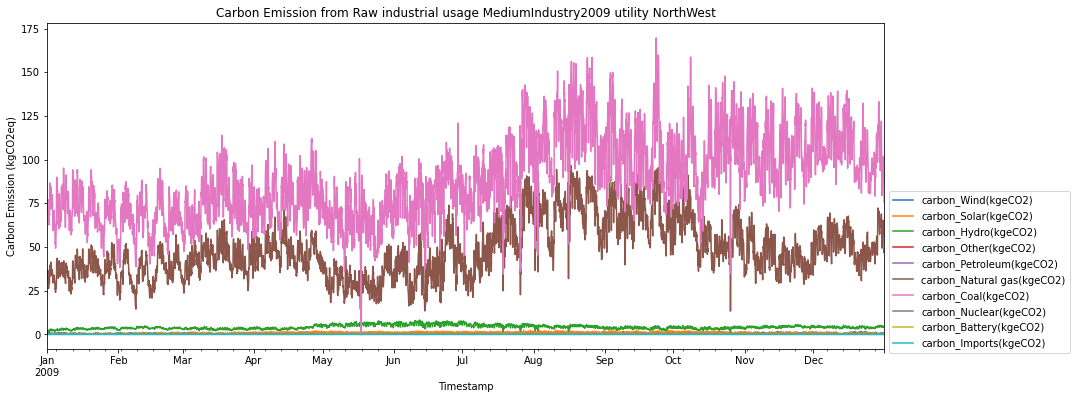

In [247]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
dfbattery_hourly.plot( 
    x = "TIME",
    y = np.array(column_list_carbon),
    title = "Carbon Emission from Raw industrial usage "+ Region +" utility "+ utilityregion ,
    ax=ax) 
ax.legend(loc='bottom left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel("Timestamp")
ax.set_ylabel("Carbon Emission (kgCO2eq)")
# ax.set_xticklabels(months_list)

# Difference in carbon emisson from raw and BTM storage

In [234]:
# dfindus_hourly.size # 219000
# dfbattery_hourly.size # 219000


dfindus_hourly.head()
dfbattery_hourly.head()

,power(W),TIME,DATE,Wind(W),Solar(W),Hydro(W),Other(W),Petroleum(W),Natural gas(W),Coal(W),Nuclear(W),Battery(W),Imports(W),total(W),carbon_Wind(kgeCO2),carbon_Solar(kgeCO2),carbon_Hydro(kgeCO2),carbon_Other(kgeCO2),carbon_Petroleum(kgeCO2),carbon_Natural gas(kgeCO2),carbon_Coal(kgeCO2),carbon_Nuclear(kgeCO2),carbon_Battery(kgeCO2),carbon_Imports(kgeCO2),carbon_total(kgeCO2)
0,317799.776036,2009-01-01 00:00:00,2009-01-01,61806.011684,-8.038238,75141.448462,8142.735055,482.294278,69345.878892,93645.472249,9243.973655,0.0,0.0,317799.776036,0.741672,-0.000386,1.803395,0.195426,0.236324,33.979481,76.789287,0.110928,0.0,0.0,113.856126
1,319093.034714,2009-01-01 01:00:00,2009-01-01,63785.689544,-16.458699,73405.799346,8599.670439,493.760982,70574.903049,92769.459196,9480.210857,0.0,0.0,319093.034714,0.765428,-0.000790,1.761739,0.206392,0.241943,34.581702,76.070957,0.113763,0.0,0.0,113.741134
2,319093.034714,2009-01-01 02:00:00,2009-01-01,61209.882022,8.420674,72333.592870,8951.176859,496.819788,72569.371752,93823.153871,9700.616878,0.0,0.0,319093.034714,0.734519,0.000404,1.736006,0.214828,0.243442,35.558992,76.934986,0.116407,0.0,0.0,115.539585
3,319093.034714,2009-01-01 03:00:00,2009-01-01,58596.605346,0.000000,76017.447534,8901.718775,510.127150,73347.782113,91950.418865,9768.934931,0.0,0.0,319093.034714,0.703159,0.000000,1.824419,0.213641,0.249962,35.940413,75.399343,0.117227,0.0,0.0,114.448165
4,319093.034714,2009-01-01 04:00:00,2009-01-01,55867.391333,-8.560740,75154.739276,8928.852155,505.083679,74889.356326,93937.003539,9819.169148,0.0,0.0,319093.034714,0.670409,-0.000411,1.803714,0.214292,0.247491,36.695785,77.028343,0.117830,0.0,0.0,116.777453


In [241]:
df_carbondiff = dfbattery_hourly[np.array(column_list_carbon)] - dfindus_hourly[np.array(column_list_carbon)]
# df_carbondiff = dfbattery_hourly.subtract(dfindus_hourly, axis = 1)
df_carbondiff.head()

,carbon_Wind(kgeCO2),carbon_Solar(kgeCO2),carbon_Hydro(kgeCO2),carbon_Other(kgeCO2),carbon_Petroleum(kgeCO2),carbon_Natural gas(kgeCO2),carbon_Coal(kgeCO2),carbon_Nuclear(kgeCO2),carbon_Battery(kgeCO2),carbon_Imports(kgeCO2)
0,0.012415,-0.000006,0.030188,0.003271,0.003956,0.568796,1.285406,0.001857,0.0,0.0
1,0.017590,-0.000018,0.040486,0.004743,0.005560,0.794718,1.748177,0.002614,0.0,0.0
2,0.016880,0.000009,0.039895,0.004937,0.005595,0.817176,1.768033,0.002675,0.0,0.0
3,0.014573,0.000000,0.037810,0.004428,0.005180,0.744846,1.562612,0.002429,0.0,0.0
4,0.016919,-0.000010,0.045521,0.005408,0.006246,0.926101,1.943985,0.002974,0.0,0.0


## graph for difference in Carbon footprint

Text(0, 0.5, 'Carbon Emission (kgCO2eq)')

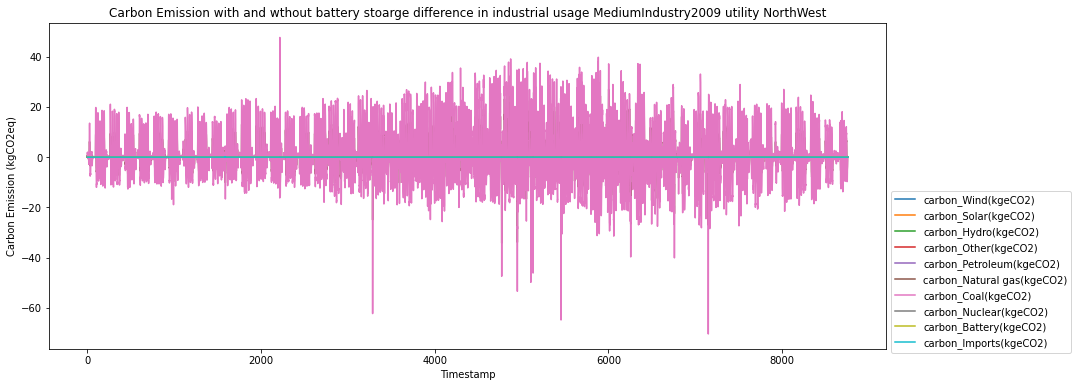

In [250]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
df_carbondiff.plot( 
    y = np.array(column_list_carbon),
    title = "Carbon Emission with and wthout battery stoarge difference in industrial usage "+ Region +" utility "+ utilityregion ,
    ax=ax) 
ax.legend(loc='bottom left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel("Timestamp")
ax.set_ylabel("Carbon Emission (kgCO2eq)")
# ax.set_xticklabels(months_list)

## To csv

In [ ]:
df_carbondiff.to_csv("df_carbondiff.csv",index=True, header=True)